# Numerical exercise 11

First of all I reproduce the previous results just to warm up a bit with Keras and Tensorflow. I try to code it using classes just to practice a bit, knowing that in `exercise 11.3` i'll ned polynomials.

In [1]:
class PolyModel:

    def __init__(self,degree):
        self.degree=degree

    def set_parameters(self,params):
        if(len(params)!=self.degree+1):
            raise ValueError('len of params list is different to the degree chosen')
        else:
            self.parameters=params
            
    def get_parameters(self):
        return self.parameters

    def evaluate(self,x):
        value=0
        for i in range(0,len(self.parameters)):
            value+=(x**i)*self.parameters[i]
        return value

Now, i build my linear fit $f(x) = 2x + 1$

In [4]:
linearFit = PolyModel(1)
linearFit.set_parameters([1,2])
linearFit.get_parameters()

[1, 2]

Let's import all the libraries i need for the exercise:

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from plot_keras_history import show_history, plot_history

Now i'll code a class that will contain all my model features and a class for data handling

In [197]:
class Data():
    
    #set the seed and the targeted model
    def __init__(self, fitTarget):
        np.random.seed(0)
        self.fitTarget = fitTarget       #element of the PolyModel class
    
    #generate data according to our fitTarget and add a noise
    def generateData(self,trainSize, valSize, sigma):
        
        #generate my training set
        self.xtrain = np.random.uniform(-1, 1, trainSize)
        self.ytrain = np.random.normal(self.fitTarget.evaluate(self.xtrain), sigma)
        
        #generate my validation set
        self.xvalid = np.random.uniform(-1, 1, valSize)
        self.xvalid.sort()
        self.yvalid = np.random.normal(self.fitTarget.evaluate(self.xvalid), sigma)
        
        #generate target set for data visualization
        self.ytarget = self.fitTarget.evaluate(self.xvalid) 
    
    def generateTestData(self, testSize):
        
        return np.random.uniform(-1, 1, testSize)
        
    def plotValidation(self):
    
        
        plt.plot(self.xvalid, self.ytarget, label='Theory')
        plt.scatter(self.xvalid, self.yvalid, color='r', label='Validation data')
        plt.legend()
        plt.grid(True)
        plt.show()

class Model():
    
    #initialize
    def __init__(self, data):
        self.data = data
    
    #set new data
    def set_data(self, data):
        self.data = data
    
    # model which considers a single neuron
    def singleNeuronModel(self):
        model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])
        self.model = model
    
    #it compiles every model
    def compile(self):
        self.model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
        
    # returns the summary of the model
    def summary(self):
        return self.model.summary()
    
    # training
    def fit(self, EarlyStopping, patience, epochs, verbose='auto'):
        
        callbacks=[]
        
        if (EarlyStopping):
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
                callbacks.append(early_stopping)
                print('Doing early stopping with patience =',patience)
                
        history = self.model.fit(x = self.data.xtrain,
                                 y = self.data.ytrain,
                                 batch_size = 32,
                                 epochs=epochs,
                                 shuffle = True,
                                 verbose = verbose,
                                 validation_data=(self.data.xvalid, self.data.yvalid),
                                 callbacks=callbacks)
        
        return history
    
    #make a performance evaluation
    def evaluate(self):
        
        return self.model.evaluate(self.data.xvalid, self.data.yvalid, batch_size=32, verbose=0)
    
def plotHistory(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.yscale('log')
    plt.show()

Lets start by generating the 500 data as already shown by the professor:

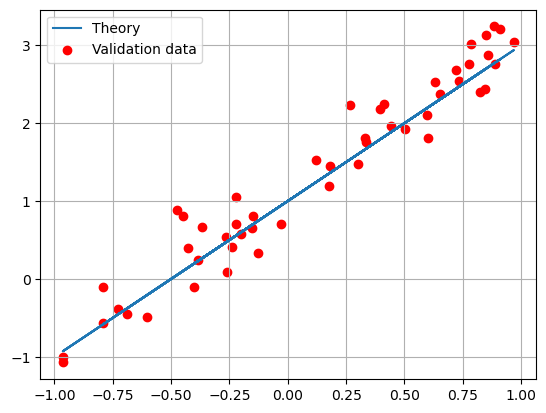

In [161]:
#initialize data class
data = Data(linearFit)

#generate and plot data
data.generateData(trainSize = 500, valSize = 50, sigma = 0.3)
data.plotValidation()

Now, let's create and compile our single neuron model (SNM):

In [84]:
#define and create the model and assign it our generated data
SNM = Model(data)
SNM.singleNeuronModel()

#compile the model
SNM.compile()
SNM.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Train the model:

In [169]:
history = SNM.fit(EarlyStopping = False , patience = 0, epochs = 30, verbose = 0)

Loss:  0.11645258963108063


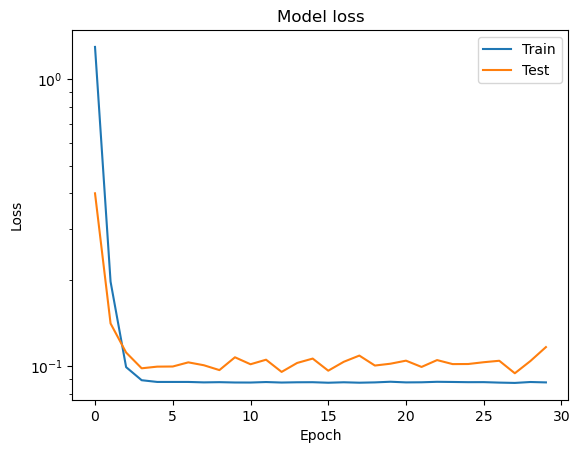

In [86]:
#model performance:

score = SNM.evaluate()
print('Loss: ', score)

plotHistory(history)

4/4 [==============================] - 0s 2ms/step


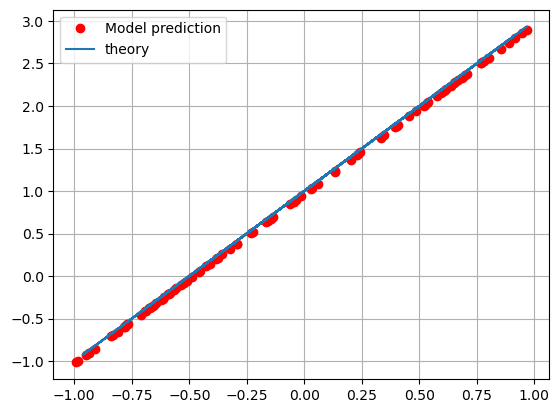

In [91]:
xtest = data.generateTestData(100)
ypred = SNM.model.predict(xtest)

plt.plot(xtest, ypred, 'o', c = 'red', label = 'Model prediction')
plt.plot(data.xvalid, data.ytarget, '-', c='tab:blue', label = 'theory')
plt.legend()
plt.grid()
plt.show()

# Exercise 11.1

## Assigment

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

So in this part we will be doing something close to a hyperoptimization of this simple model. Something that we could do is making *sns.heatmap* for different noises, let's say $\sigma \in [0, 0.3, 0.6, 1]$

In [140]:
#define our searching space for the parameters
sigmas = [0, 0.3, 0.6, 1]
NTrain = np.linspace(100, 1000, 5, dtype=int)
NEpochs = np.linspace(5, 50, 5, dtype = int)

#Define our data structure
data = Data(linearFit)
#define and create the model and assign it our generated data
SNM = Model(data)
SNM.singleNeuronModel()
SNM.compile()

In [141]:
#list of results
results = []

for sigma in sigmas:
    
    #store results in a matrix
    matrix = np.zeros((len(NTrain), len(NEpochs)))
    i = 0
    j = 0
    
    #iterate
    for trainSize in NTrain:
        
        #being a bit user friendly:
        print('Currently using: ', trainSize, ' train elements')
        
        #generate and assign data to the model
        data.generateData(trainSize=trainSize, valSize=50, sigma=sigma)
        SNM.set_data(data)

        j=0
        for epoch in NEpochs:
            
            SNM.fit(EarlyStopping = False , patience = 0, epochs = epoch, verbose=0)
            matrix[i,j] = SNM.evaluate()
            j+=1
            
        i+=1
    results.append(matrix)

Currently using:  100  train elements


2023-05-25 17:56:46.260541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-25 17:56:46.372659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Currently using:  325  train elements
Currently using:  550  train elements
Currently using:  775  train elements
Currently using:  1000  train elements
Currently using:  100  train elements
Currently using:  325  train elements
Currently using:  550  train elements
Currently using:  775  train elements
Currently using:  1000  train elements
Currently using:  100  train elements
Currently using:  325  train elements
Currently using:  550  train elements
Currently using:  775  train elements
Currently using:  1000  train elements
Currently using:  100  train elements
Currently using:  325  train elements
Currently using:  550  train elements
Currently using:  775  train elements
Currently using:  1000  train elements


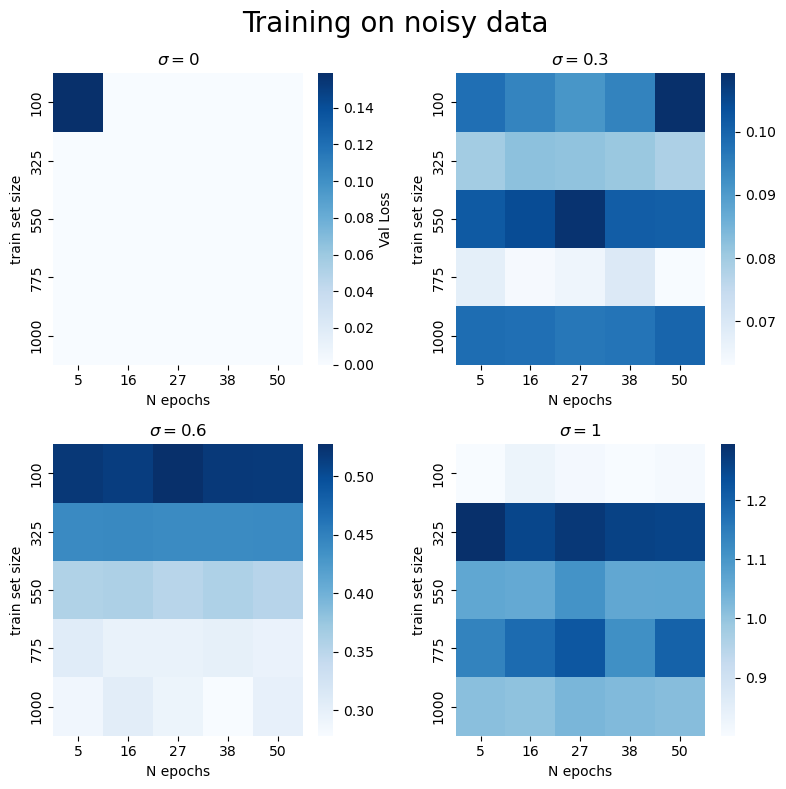

In [174]:
# Set the number of rows and columns for the subplots
num_rows = 2
num_cols = 2

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over the results and plot each heatmap with the corresponding title
for i in range(len(results)):
    ax = axes[i]
    sns.heatmap(results[i], cmap='Blues', ax=ax)
    ax.set_xlabel('N epochs')
    ax.set_ylabel('train set size')
    title = '$\sigma = $'+str(sigmas[i])
    ax.set_title(title)
    
    # Set the x and y tick labels
    ax.set_xticklabels(NEpochs)
    ax.set_yticklabels(NTrain)
    
    # Add colorbar only to the first heatmap
    if i == 0:
        cbar = ax.collections[0].colorbar
        cbar.set_label('Val Loss')  # Set the label for the colorbar


# Adjust the spacing between subplots
fig.suptitle('Training on noisy data', fontsize=20)
plt.tight_layout()


# Display the plot
plt.show()

# Exercise 11.2

## Assigment

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

In order to make practice with NN, explore reasonable different choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Make graphs comparing fits for different NNs.
Check your NN models by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

First of all we need a new object of our class `PolyModel`

In [179]:
cubicFit = PolyModel(3)
cubicFit.set_parameters([4,-3,-2,3])
cubicFit.get_parameters()

[4, -3, -2, 3]

Now i can generate data according to my function:

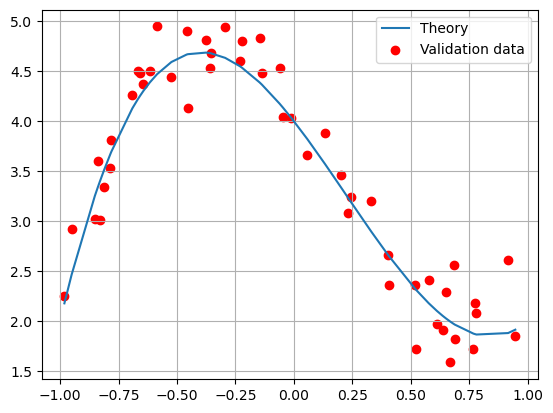

In [182]:
data = Data(cubicFit)
data.generateData(trainSize=750, valSize=50, sigma=0.3)
data.plotValidation()

In terms of data, i will stick as benchmark to:

- trainSize = 750
- valSize = 50
- sigma = 0.3

Now in order to test the best architecture for my NN i could design a simple Hyperoptimization using `hyperopt` library

In [185]:
#import everything i need from the hyperopt library
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK

Then i should add a method to my class `Model()` so that I can construct a trial dense model

In [306]:
class Model():
    
    #initialize
    def __init__(self, data):
        self.data = data
    
    #set new data
    def set_data(self, data):
        self.data = data
    
    # model which considers a single neuron
    def singleNeuronModel(self):
        model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])
        self.model = model
        
    def trialModel(self, params):
        
        model = tf.keras.models.Sequential()
        #a single neuron as input
        model.add(tf.keras.layers.Dense(units=params['input_units'], activation=params['activation'], input_shape=(1,)))
        #hidden layers
        for i in range(1, params['num_hidden_layers']):
            model.add(tf.keras.layers.Dense(units=params[f'layer_size{i}'], activation=params['activation']))
        #output neuron
        model.add(tf.keras.layers.Dense(units=1))
            
        self.model = model
    
    #it compiles every model
    def compile(self):
        self.model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
    
    #Compilation for hyperopt
    def compileTrial(self, params):
        
        if params['optimizer'] == 'SGD':
            
            optimizer = tf.keras.optimizers.SGD(learning_rate=params['lr'])
            
        elif params['optimizer'] == 'Adam':
            
             optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
                
        self.model.compile(optimizer=optimizer, loss=params['loss'])
    
    #trains the trial model
    def fitTrial(self, epochs = 25, verbose=0):
        
        self.model.fit(x = self.data.xtrain,
                       y = self.data.ytrain,
                       batch_size = 32,
                       epochs=epochs,
                       shuffle = True,
                       verbose = verbose,
                       validation_data=(self.data.xvalid, self.data.yvalid)
                       )
        
    #defines, compiles and fits the trial model
    def trialShot(self, params):
        
        self.trialModel(params)
        self.compileTrial(params)
        self.fitTrial()
        return self.model
        
    # returns the summary of the model
    def summary(self):
        return self.model.summary()

    
    # training
    def fit(self, EarlyStopping, patience, epochs, verbose='auto'):
        
        callbacks=[]
        
        if (EarlyStopping):
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
                callbacks.append(early_stopping)
                print('Doing early stopping with patience =',patience)
                
        history = self.model.fit(x = self.data.xtrain,
                                 y = self.data.ytrain,
                                 batch_size = 32,
                                 epochs=epochs,
                                 shuffle = True,
                                 verbose = verbose,
                                 validation_data=(self.data.xvalid, self.data.yvalid),
                                 callbacks=callbacks)
        
        return history
    
    #make a performance evaluation
    def evaluate(self):
        
        return self.model.evaluate(self.data.xvalid, self.data.yvalid, batch_size=32, verbose=0)


Let's try a test configuration of the trail model:

In [308]:
test_setup = {
    'num_hidden_layers' : 2,
    'input_units': 4,
    'layer_size1' : 10,
    'layer_size2' : 10,
    'activation' : 'relu',
    'optimizer' : 'Adam',
    'lr' : 0.1,
    'loss' : 'mean_absolute_error'   
}

model = Model(data)
model.trialShot(test_setup)
model.summary()

print(model.evaluate())

2023-05-26 11:43:25.304100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:43:25.955155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_392 (Dense)           (None, 8)                 16        
                                                                 
 dense_393 (Dense)           (None, 10)                90        
                                                                 
 dense_394 (Dense)           (None, 1)                 11        
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
0.2793514132499695


We need to implement an objective function:

In [298]:
def hyper_func(params):
    
    model.trialShot(params)
    loss = model.evaluate()
    
    return {'loss': loss, 'status': STATUS_OK}

Now we can set up the hyperoptimization:

In [310]:
search_space = {
    'num_hidden_layers': hp.choice('num_hidden_layers', [1,2,3]),  
    'input_units': hp.choice('input_units', np.arange(2,12,1)),
    'layer_size1': hp.choice('layer_size1', [8,12,16]),
    'layer_size2': hp.choice('layer_size2', [8,12,16]),
    'layer_size3': hp.choice('layer_size3', [8,12,16]),
    'activation' : hp.choice('activation',['relu','softmax']),
    'optimizer' : hp.choice('optimizer',['Adam','SGD']),
    'lr' : hp.loguniform('learning_rate', -10, 0),
    'loss' : hp.choice('loss', ['mean_absolute_error', 'mean_squared_error'])        
}

In [311]:
trials = Trials()
best = fmin (hyper_func, search_space, algo = tpe.suggest, max_evals=15, trials=trials)
print(space_eval(search_space, best))

  0%|                                    | 0/15 [00:00<?, ?trial/s, best loss=?]

2023-05-26 11:44:11.117110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:11.558121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7%|▋         | 1/15 [00:06<01:27,  6.26s/trial, best loss: 0.6657448410987854]

2023-05-26 11:44:17.332037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:17.868882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 13%|█▏       | 2/15 [00:12<01:23,  6.40s/trial, best loss: 0.26496678590774536]

2023-05-26 11:44:24.686137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:25.455994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20%|█▊       | 3/15 [00:21<01:31,  7.62s/trial, best loss: 0.26496678590774536]

2023-05-26 11:44:32.902203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:33.392198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 27%|██▍      | 4/15 [00:29<01:22,  7.46s/trial, best loss: 0.26496678590774536]

2023-05-26 11:44:40.152944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:41.007934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 33%|███      | 5/15 [00:37<01:18,  7.83s/trial, best loss: 0.26496678590774536]

2023-05-26 11:44:48.583791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:49.107319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 40%|███▌     | 6/15 [00:43<01:04,  7.20s/trial, best loss: 0.26496678590774536]

2023-05-26 11:44:54.579446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:44:55.285670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 47%|████▏    | 7/15 [00:50<00:58,  7.29s/trial, best loss: 0.26496678590774536]

2023-05-26 11:45:02.078036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:02.774566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 53%|████▊    | 8/15 [00:58<00:51,  7.40s/trial, best loss: 0.24926446378231049]

2023-05-26 11:45:09.713790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:10.389261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 60%|█████▍   | 9/15 [01:06<00:46,  7.68s/trial, best loss: 0.24926446378231049]

2023-05-26 11:45:18.015996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:18.822812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 67%|█████▎  | 10/15 [01:15<00:39,  7.85s/trial, best loss: 0.24926446378231049]

2023-05-26 11:45:26.237214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:26.990233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 73%|█████▊  | 11/15 [01:23<00:32,  8.04s/trial, best loss: 0.24926446378231049]

2023-05-26 11:45:34.681026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:35.238900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 80%|██████▍ | 12/15 [01:30<00:23,  7.78s/trial, best loss: 0.24926446378231049]

2023-05-26 11:45:41.881925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:42.500559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 87%|██████▉ | 13/15 [01:38<00:15,  7.68s/trial, best loss: 0.10260850191116333]

2023-05-26 11:45:49.319093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:49.727154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 93%|███████▍| 14/15 [01:44<00:07,  7.33s/trial, best loss: 0.10260850191116333]

2023-05-26 11:45:55.836751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:45:56.370004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100%|████████| 15/15 [01:51<00:00,  7.46s/trial, best loss: 0.10260850191116333]
{'activation': 'relu', 'input_units': 7, 'layer_size1': 12, 'layer_size2': 8, 'layer_size3': 12, 'loss': 'mean_squared_error', 'lr': 0.009341966403972482, 'num_hidden_layers': 3, 'optimizer': 'SGD'}


Now that I found the proper combination of paramters for the achitecture, I can build up the NN accordingly and train it with more data:

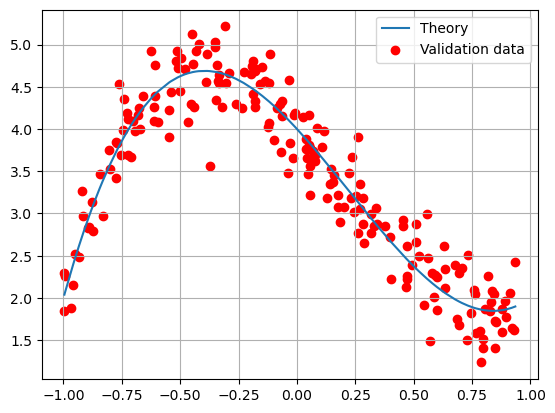

In [312]:
params = space_eval(search_space, best)

data = Data(cubicFit)
data.generateData(trainSize=2000, valSize=200, sigma=0.3)
data.plotValidation()

In [313]:
model = Model(data)

model.trialModel(params)
model.compileTrial(params)
model.summary()

history= model.fit(EarlyStopping=True, patience=10, epochs=100, verbose=0)

Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_442 (Dense)           (None, 8)                 16        
                                                                 
 dense_443 (Dense)           (None, 12)                108       
                                                                 
 dense_444 (Dense)           (None, 8)                 104       
                                                                 
 dense_445 (Dense)           (None, 1)                 9         
                                                                 
Total params: 237
Trainable params: 237
Non-trainable params: 0
_________________________________________________________________
Doing early stopping with patience = 10


2023-05-26 11:46:12.962517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 11:46:13.619162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


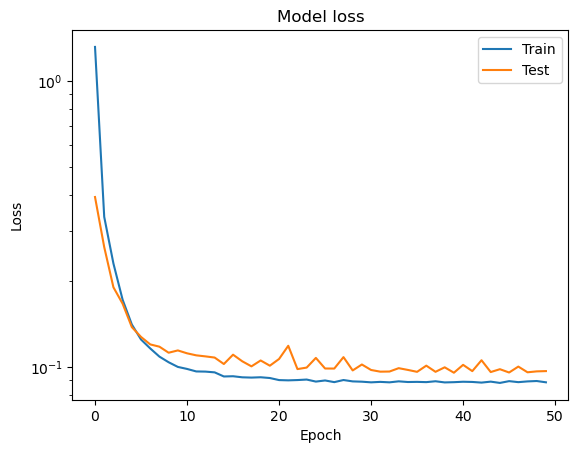

In [314]:
plotHistory(history)

Finally we can evaluate the model performace:

4/4 [==============================] - 0s 5ms/step - loss: 0.0000e+00


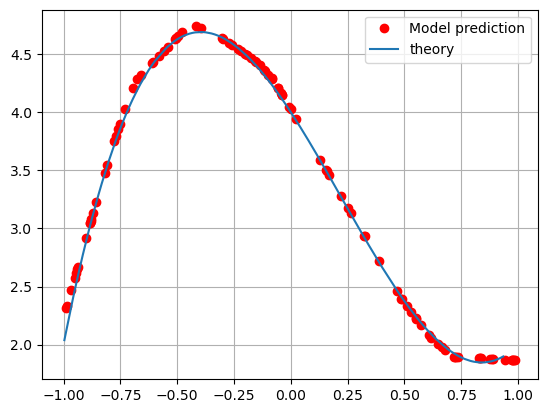

In [322]:
xtest = data.generateTestData(100)
ypred = model.model.predict(xtest)

model.model.evaluate(xtest, ypred)

plt.plot(xtest, ypred, 'o', c = 'red', label = 'Model prediction')
plt.plot(data.xvalid, data.ytarget, '-', c='tab:blue', label = 'theory')
plt.legend()
plt.grid()
plt.show()

# Exercise 11.3

## Assigment

Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

This time we need to change our data classfrom mpl_toolkits.mplot3d import Axes3D

In [344]:
#3D plots
from mpl_toolkits.mplot3d import Axes3D

In [345]:
class TrigoModel:

    def __init__(self):
        self.parameters=[1,1,1] #default parameters

    def set_parameters(self,params):
        if(len(params)!=self.degree+1):
            raise ValueError('len of params list is different to the degree chosen')
        else:
            self.parameters=params
            
    def get_parameters(self):
        return self.parameters

    def evaluate(self,x, y):
        
        return self.parameters[0] * np.sin(self.parameters[1] * x**2 + self.parameters[2] * y**2)
        

In [391]:
class Data():
    
    #set the seed and the targeted model
    def __init__(self, fitTarget):
        np.random.seed(0)
        self.fitTarget = fitTarget       #element of the PolyModel class
    
    #generate data according to our fitTarget and add a noise
    def generateData(self,trainSize, valSize, sigma):
        
        #generate my training set
        self.xtrain = np.random.uniform(-3/2, +3/2, (trainSize, 2))
        self.ytrain = np.random.normal(self.fitTarget.evaluate(self.xtrain[:,0], self.xtrain[:,1]), sigma)
        
        #generate my validation set
        self.xvalid = np.random.uniform(-3/2, +3/2, (valSize, 2))
        self.yvalid = np.random.normal(self.fitTarget.evaluate(self.xvalid[:,0], self.xvalid[:,1]), sigma)
        
        #generate target set for data visualization
        self.ytarget = self.fitTarget.evaluate(self.xvalid[:,0], self.xvalid[:,1]) 
    
    def generateTestData(self, testSize):
        
        return np.random.uniform(-3/2, +3/2, (testSize, 2))
        
    def plotValidation(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.xvalid[:, 0], self.xvalid[:, 1], self.ytarget, marker='.', color='tab:red', label='Target data')
        ax.scatter(self.xtrain[:, 0], self.xtrain[:, 1], self.ytrain, c=self.ytrain, marker='.', label='Training data')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.legend()
        ax.view_init(10, 30)
        plt.show()

In [380]:
sinFit = TrigoModel()
sinFit.get_parameters()

[1, 1, 1]

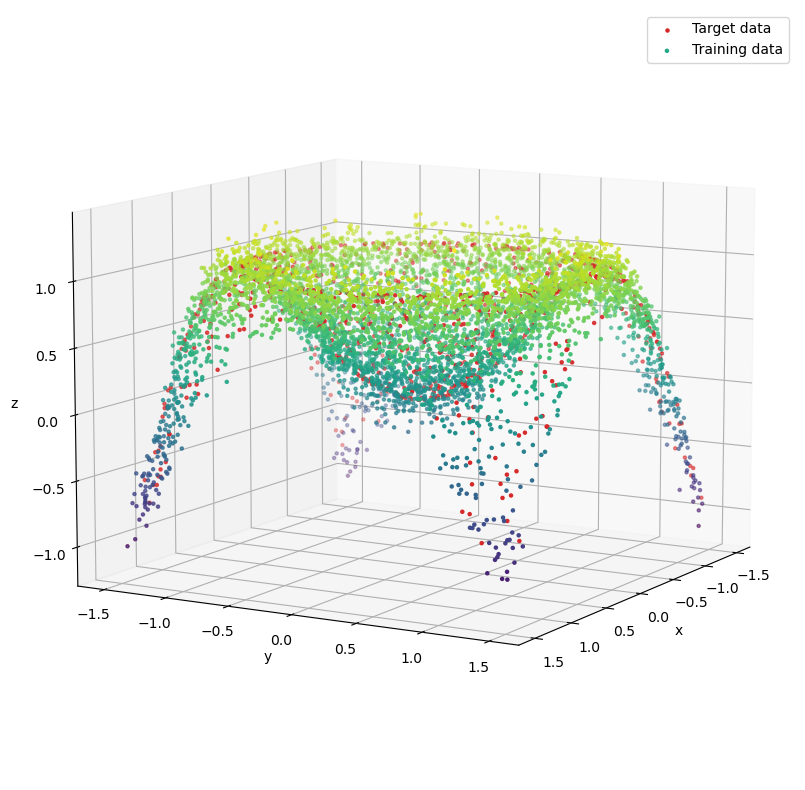

In [393]:
data = Data(sinFit)
data.generateData(trainSize=5000, valSize=1000, sigma=0.1)
data.plotValidation()

And modify the input shape of my model:

In [382]:
class Model():
    
    #initialize
    def __init__(self, data):
        self.data = data
    
    #set new data
    def set_data(self, data):
        self.data = data
    
    # model which considers a single neuron
    def singleNeuronModel(self):
        model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])
        self.model = model
        
    def trialModel(self, params):
        
        model = tf.keras.models.Sequential()
        #a single neuron as input
        model.add(tf.keras.layers.Dense(units=params['input_units'], activation=params['activation'], input_shape=(2,)))
        #hidden layers
        for i in range(1, params['num_hidden_layers']):
            model.add(tf.keras.layers.Dense(units=params[f'layer_size{i}'], activation=params['activation']))
        #output neuron
        model.add(tf.keras.layers.Dense(units=1))
            
        self.model = model
    
    #it compiles every model
    def compile(self):
        self.model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='mean_squared_error')
    
    #Compilation for hyperopt
    def compileTrial(self, params):
        
        if params['optimizer'] == 'SGD':
            
            optimizer = tf.keras.optimizers.SGD(learning_rate=params['lr'])
            
        elif params['optimizer'] == 'Adam':
            
             optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
                
        self.model.compile(optimizer=optimizer, loss=params['loss'])
    
    #trains the trial model
    def fitTrial(self, epochs = 25, verbose=0):
        
        self.model.fit(x = self.data.xtrain,
                       y = self.data.ytrain,
                       batch_size = 32,
                       epochs=epochs,
                       shuffle = True,
                       verbose = verbose,
                       validation_data=(self.data.xvalid, self.data.yvalid)
                       )
        
    #defines, compiles and fits the trial model
    def trialShot(self, params):
        
        self.trialModel(params)
        self.compileTrial(params)
        self.fitTrial()
        return self.model
        
    # returns the summary of the model
    def summary(self):
        return self.model.summary()

    
    # training
    def fit(self, EarlyStopping, patience, epochs, verbose='auto'):
        
        callbacks=[]
        
        if (EarlyStopping):
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
                callbacks.append(early_stopping)
                print('Doing early stopping with patience =',patience)
                
        history = self.model.fit(x = self.data.xtrain,
                                 y = self.data.ytrain,
                                 batch_size = 32,
                                 epochs=epochs,
                                 shuffle = True,
                                 verbose = verbose,
                                 validation_data=(self.data.xvalid, self.data.yvalid),
                                 callbacks=callbacks)
        
        return history
    
    #make a performance evaluation
    def evaluate(self):
        
        return self.model.evaluate(self.data.xvalid, self.data.yvalid, batch_size=32, verbose=0)


In [383]:
model = Model(data)
model.trialShot(test_setup)
model.summary()

print(model.evaluate())

2023-05-26 12:14:25.626251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:14:26.814544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_452 (Dense)           (None, 4)                 12        
                                                                 
 dense_453 (Dense)           (None, 10)                50        
                                                                 
 dense_454 (Dense)           (None, 1)                 11        
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
0.31265801191329956


In [384]:
trials = Trials()
best = fmin (hyper_func, search_space, algo = tpe.suggest, max_evals=15, trials=trials)
print(space_eval(search_space, best))

  0%|                                    | 0/15 [00:00<?, ?trial/s, best loss=?]

2023-05-26 12:14:49.867787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:14:50.785651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  7%|▋         | 1/15 [00:16<03:49, 16.40s/trial, best loss: 0.2806435227394104]

2023-05-26 12:15:06.280995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:15:07.881159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 13%|█▎        | 2/15 [00:37<04:07, 19.04s/trial, best loss: 0.2806435227394104]

2023-05-26 12:15:27.162151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:15:28.833348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20%|██        | 3/15 [01:00<04:13, 21.17s/trial, best loss: 0.1594277024269104]

2023-05-26 12:15:50.825479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:15:51.952675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 27%|██▋       | 4/15 [01:21<03:49, 20.90s/trial, best loss: 0.1594277024269104]

2023-05-26 12:16:11.348670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:16:12.551576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 33%|███▎      | 5/15 [01:38<03:15, 19.58s/trial, best loss: 0.1594277024269104]

2023-05-26 12:16:28.561600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:16:29.495592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 40%|████      | 6/15 [01:54<02:43, 18.21s/trial, best loss: 0.1538492739200592]

2023-05-26 12:16:44.131648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:16:45.614122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 47%|███▋    | 7/15 [02:13<02:29, 18.70s/trial, best loss: 0.013616508804261684]

2023-05-26 12:17:03.788552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:17:04.655361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 53%|████▎   | 8/15 [02:30<02:05, 17.95s/trial, best loss: 0.013616508804261684]

2023-05-26 12:17:20.138711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:17:21.972045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 60%|████▊   | 9/15 [02:49<01:49, 18.23s/trial, best loss: 0.013616508804261684]

2023-05-26 12:17:38.981870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:17:39.912622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 67%|████▋  | 10/15 [03:03<01:25, 17.18s/trial, best loss: 0.013616508804261684]

2023-05-26 12:17:53.786170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:17:54.592242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 73%|█████▏ | 11/15 [03:18<01:05, 16.43s/trial, best loss: 0.013616508804261684]

2023-05-26 12:18:08.564253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:18:09.603612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 80%|█████▌ | 12/15 [03:38<00:52, 17.43s/trial, best loss: 0.013616508804261684]

2023-05-26 12:18:28.252279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:18:29.075315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 87%|██████ | 13/15 [03:53<00:33, 16.66s/trial, best loss: 0.013616508804261684]

2023-05-26 12:18:43.130436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:18:43.815575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 93%|██████▌| 14/15 [04:07<00:16, 16.05s/trial, best loss: 0.013616508804261684]

2023-05-26 12:18:57.807112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:18:58.654901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100%|███████| 15/15 [04:23<00:00, 17.56s/trial, best loss: 0.013616508804261684]
{'activation': 'relu', 'input_units': 7, 'layer_size1': 12, 'layer_size2': 8, 'layer_size3': 12, 'loss': 'mean_squared_error', 'lr': 0.010202237000423128, 'num_hidden_layers': 2, 'optimizer': 'Adam'}


In [385]:
params = space_eval(search_space, best)
model.trialModel(params)
model.compileTrial(params)
model.summary()

history= model.fit(EarlyStopping=True, patience=10, epochs=100, verbose=0)

Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_495 (Dense)           (None, 7)                 21        
                                                                 
 dense_496 (Dense)           (None, 12)                96        
                                                                 
 dense_497 (Dense)           (None, 1)                 13        
                                                                 
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________
Doing early stopping with patience = 10


2023-05-26 12:19:13.330112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-26 12:19:14.382648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


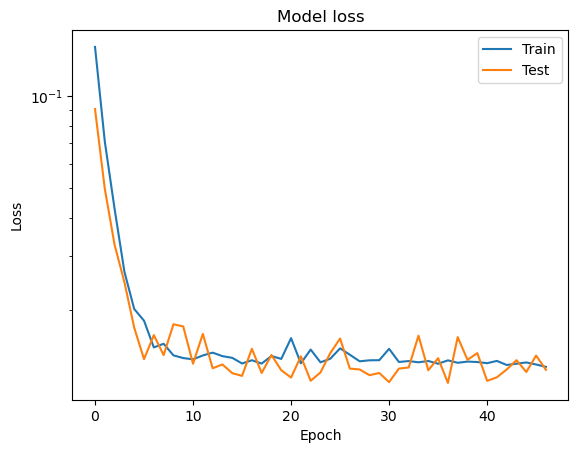

In [386]:
plotHistory(history)

157/157 [==============================] - 1s 3ms/step - loss: 0.0000e+00


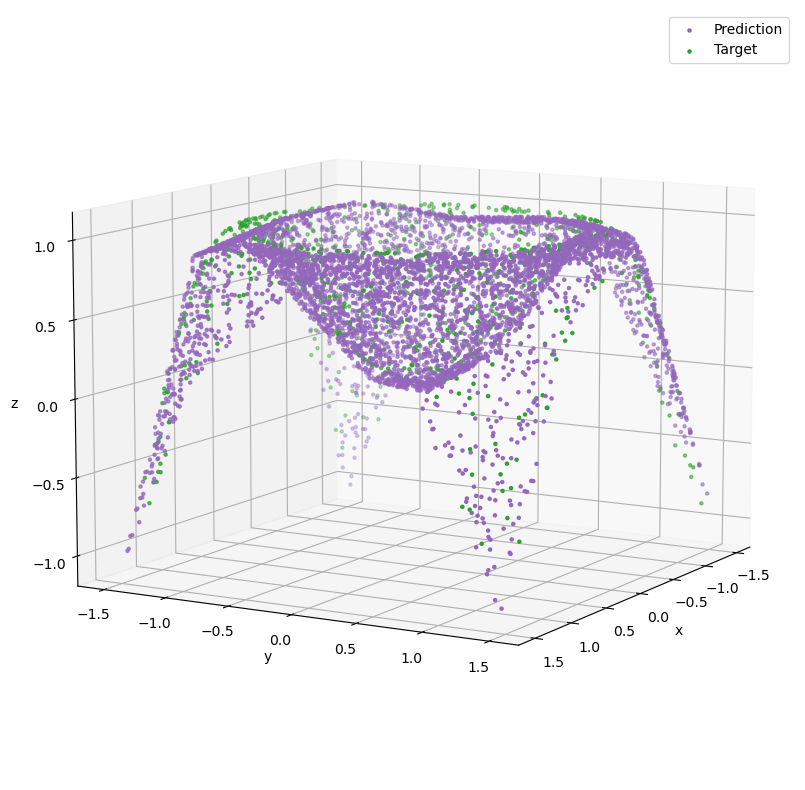

In [396]:
xtest = data.generateTestData(5000)
ypred = model.model.predict(xtest)

model.model.evaluate(xtest, ypred)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xtest[:, 0], xtest[:, 1], ypred, marker='.', color='tab:purple', label='Prediction')
ax.scatter(model.data.xvalid[:, 0], model.data.xvalid[:, 1], model.data.ytarget, c='tab:green', marker='.', label='Target')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
ax.view_init(10, 30)
plt.show()